In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import subprocess, glob
import pyranges as pr
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import plotly.express as px

In [3]:
import os

os.environ["R_HOME"] = "/home/murrelab/anaconda3/envs/r-wgcna/lib/R"
import rpy2
from rpy2.robjects import r, pandas2ri, globalenv, FloatVector, StrVector, IntVector

%load_ext rpy2.ipython

In [4]:
%%R
suppressPackageStartupMessages(library(ComplexHeatmap))
library(repr)
library(circlize)

R[write to console]: ========================================
circlize version 0.4.14
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




# Create AnnData Object

In [5]:
signal = pd.read_csv("0622_All_Samples_Signal_at_Consensus_Peaks.txt", sep="\t")
# signal = signal[signal.Chromosome != "chrX"]

signal_ad = ad.AnnData(signal.iloc[:, 3:].values.T, dtype=np.float64)
signal_ad.obs_names = list(signal.columns[3:])
signal_ad.var_names = signal.apply(
    lambda row: ":".join([row.Chromosome, str(row.Start), str(row.End)]), axis=1
)

# remove monocytes
signal_ad = signal_ad[~signal_ad.obs_names.str.endswith("M"), :].copy()

# sample info
signal_ad.obs["ATAC_ID"] = [name.split("_")[0] for name in signal_ad.obs.index.values]
signal_ad.obs["Sample_ID"] = [
    name.split("_")[2].split(".")[0] for name in signal_ad.obs.index.values
]
signal_ad.obs["Genotype"] = [name.split("_")[3] for name in signal_ad.obs.index.values]

# filter low express regions
print(signal_ad)
keep_genes = np.sum(signal_ad.X >= 4, axis=0) >= 14
signal_ad = signal_ad[:, keep_genes].copy()
print("Filter low expression regions")
print(signal_ad)

# log transform
sc.pp.log1p(signal_ad)

AnnData object with n_obs × n_vars = 70 × 94605
    obs: 'ATAC_ID', 'Sample_ID', 'Genotype'
Filter low expression regions
AnnData object with n_obs × n_vars = 70 × 48788
    obs: 'ATAC_ID', 'Sample_ID', 'Genotype'


In [256]:
sc.pp.highly_variable_genes(signal_ad, n_top_genes=30000)  # , flavor="seurat_v3")
adata = signal_ad[:, signal_ad.var.highly_variable].copy()
# adata = signal_ad.copy()
sc.pp.scale(adata, max_value=10)

# UMAP

In [250]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=3, n_pcs=30, metric="cosine")
sc.tl.leiden(adata, resolution=2)
sc.tl.umap(adata, min_dist=0.3, n_components=2)

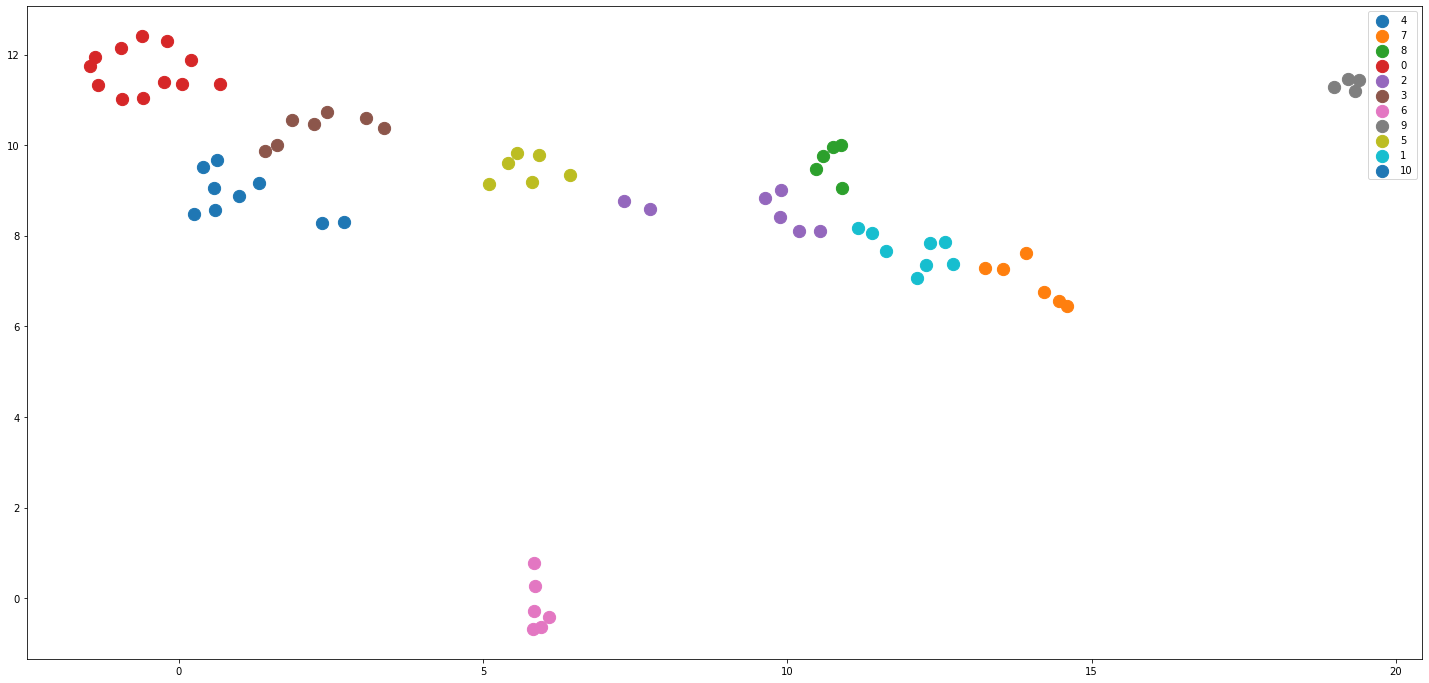

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(25, 12))
data = adata.obsm["X_umap"]
x, y = data[:, 0], data[:, 1]
for gt in adata.obs.leiden.unique():
    idx = adata.obs.leiden == gt
    ax.scatter(x[idx], y[idx], label=gt, s=150)
    ax.legend()

In [252]:
data = adata.obsm["X_umap"]
df = pd.DataFrame(
    {
        "x": data[:, 0],
        "y": data[:, 1],
        "Genotype": adata.obs.Genotype,
        "leiden": adata.obs.leiden,
        "label": adata.obs.Sample_ID,
    }
)
fig = px.scatter(df, x="x", y="y", color="Genotype", hover_name="label")
fig.update_traces(
    marker=dict(
        size=12,
        line=dict(width=2, color="DarkSlateGrey"),
    ),
    selector=dict(mode="markers"),
)
fig.write_html("scatter.html")

# Sample Similarity

## Original signal input

In [257]:
n, m = adata.X.shape
globalenv["X"] = r.matrix(
    FloatVector(adata.X.reshape(n * m)), nrow=n, ncol=m, byrow=True
)
globalenv["samples.names"] = StrVector(adata.obs_names)
globalenv["genotype"] = pandas2ri.py2rpy(adata.obs.Genotype)

In [258]:
%%R
rownames(X) <- samples.names
X <- t(X)

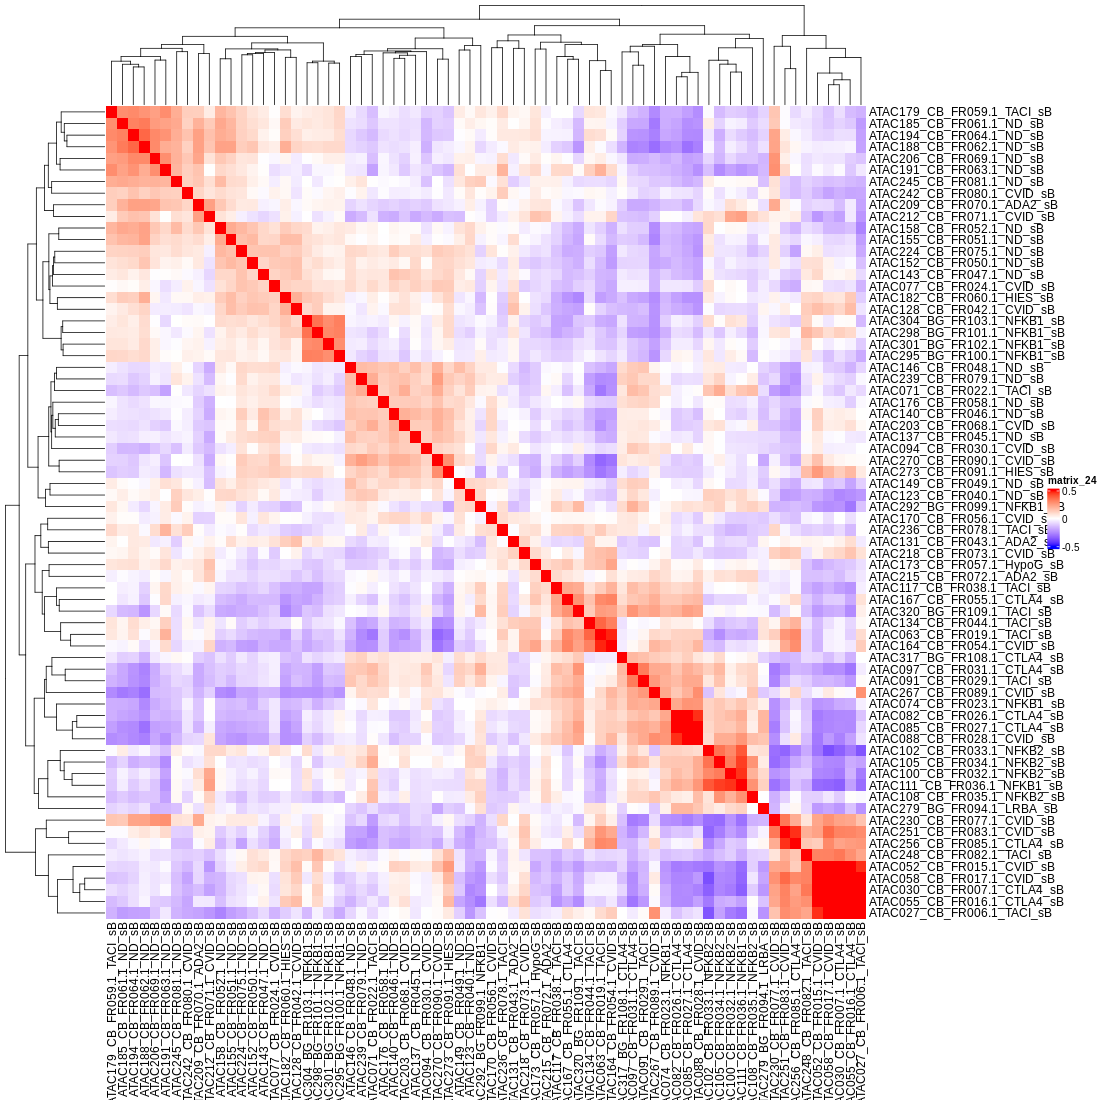

In [259]:
%%R -w 1100 -h 1100
n_samples <- ncol(X)
cor_mat <- cor(X)

colha <- HeatmapAnnotation(
    Locus = genotype[rownames(cor_mat)], 
    which="col" 
)

cl_method <- "average"
Heatmap(
    cor_mat, 
    row_dend_width = n_samples * unit(0.5, "mm"),
    column_dend_height  = n_samples * unit(0.5, "mm"),
    col=colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red")),
    clustering_method_rows = cl_method,
    clustering_method_columns = cl_method,
    # top_annotation = colha
)

## Dimensional reduced input

In [397]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=30)
sc.tl.leiden(adata, resolution=1)
sc.tl.umap(adata, min_dist=0.3, n_components=20)

In [403]:
reduction = "pca"
n, m = adata.obsm["X_" + reduction].shape
globalenv["sample.embedding"] = r.matrix(
    FloatVector(adata.obsm["X_" + reduction].reshape(n * m)), nrow=n, ncol=m, byrow=True
)
globalenv["samples.names"] = StrVector(adata.obs_names)
globalenv["genotype"] = pandas2ri.py2rpy(adata.obs.Genotype)

In [404]:
%%R
max.dims <- 50
rownames(sample.embedding) <- samples.names
sample.embedding <- t(sample.embedding[,1:max.dims])
# head(sample.embedding)

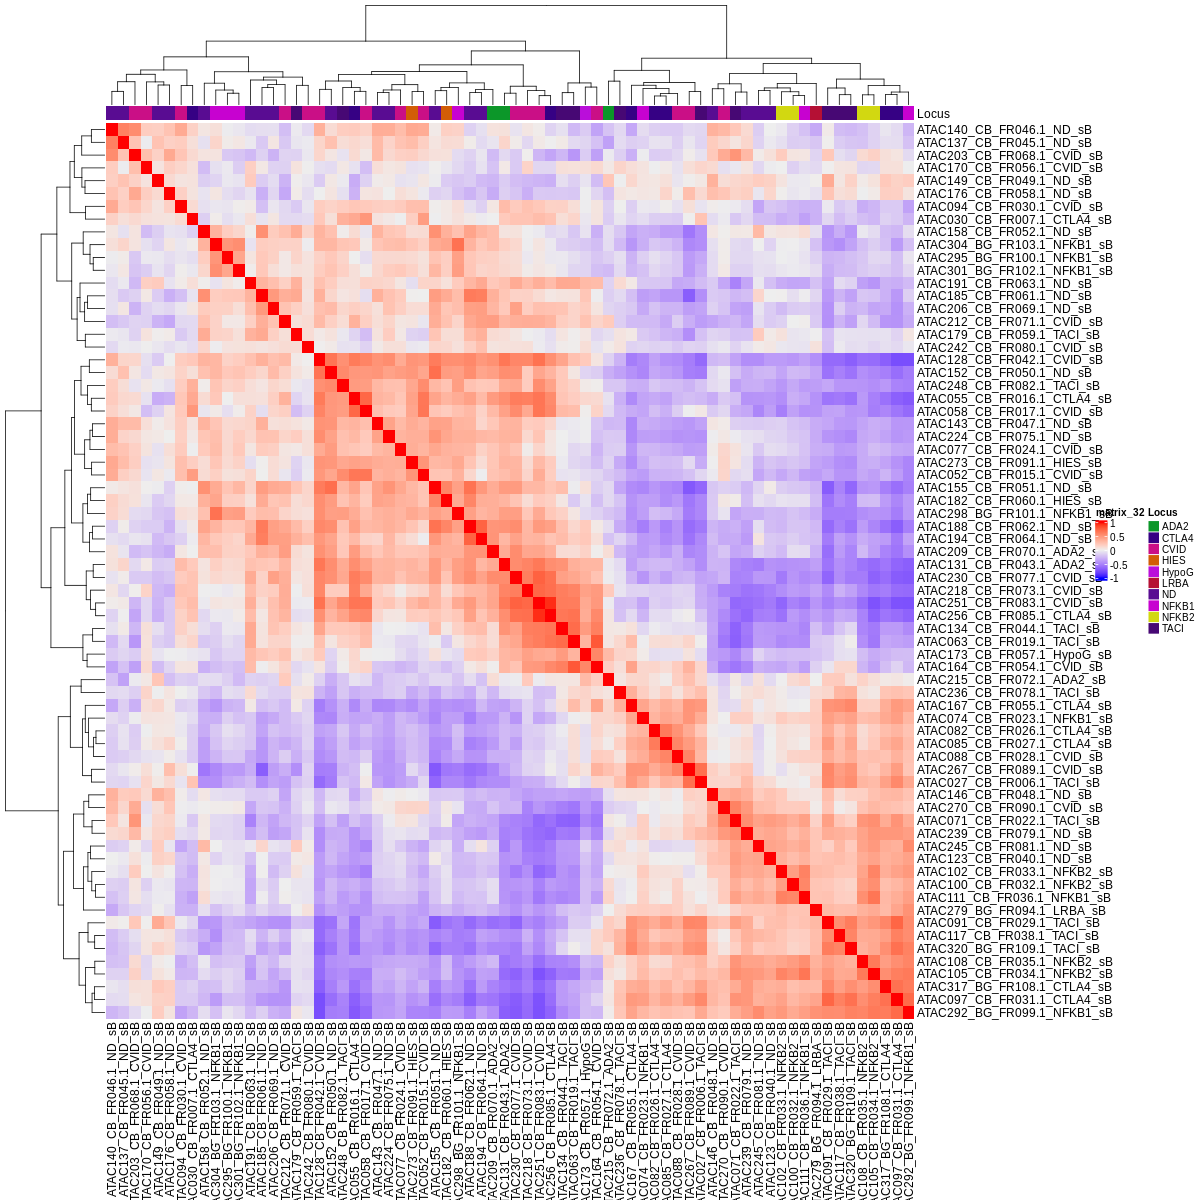

In [405]:
%%R -w 1200 -h 1200
# options(repr.plot.width=15, repr.plot.height=15)
n_samples <- ncol(sample.embedding)
cor_mat <- cor(sample.embedding)

colha <- HeatmapAnnotation(
    Locus = genotype[rownames(cor_mat)], 
    which="col" 
)

Heatmap(
    cor_mat, 
    row_dend_width = n_samples * unit(0.5, "mm"),
    column_dend_height  = n_samples * unit(0.5, "mm"),
    # col=colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red"))
    top_annotation = colha
)

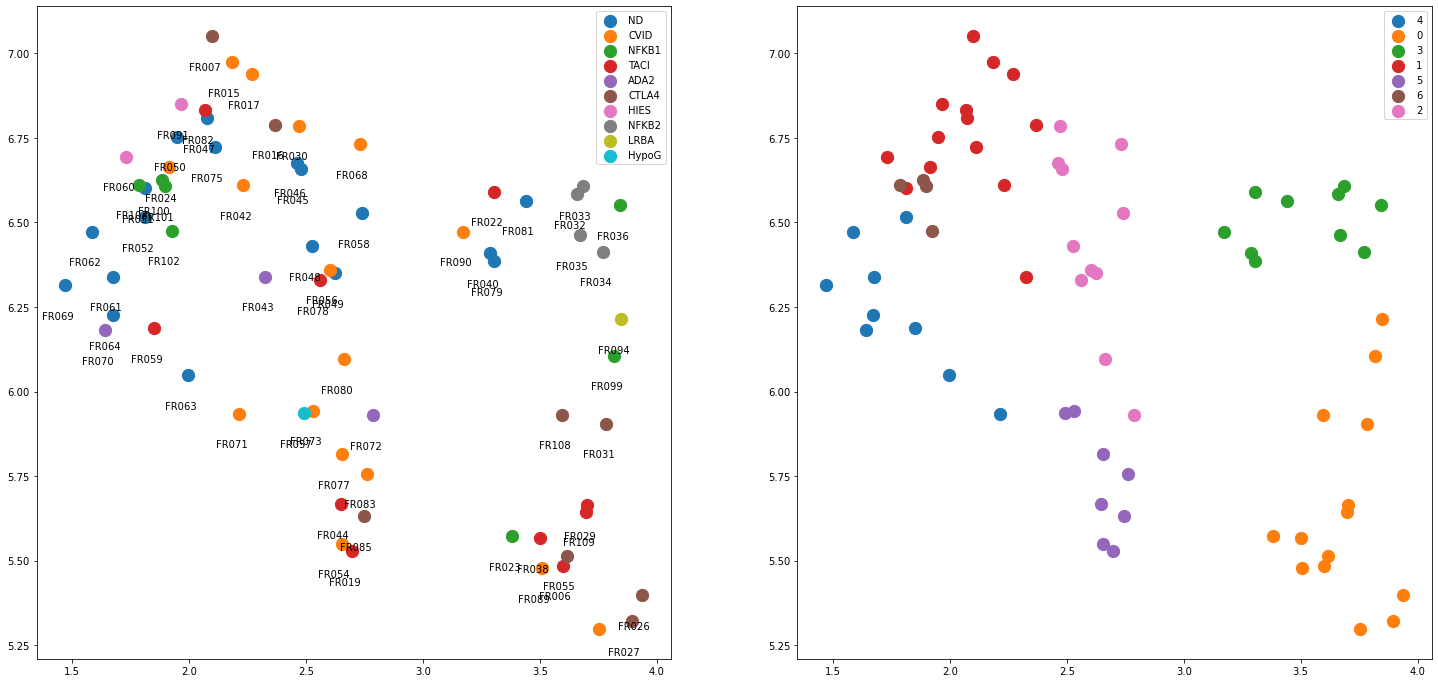

In [406]:
fig, axes = plt.subplots(1, 2, figsize=(25, 12))
data = adata.obsm["X_umap"]
x, y = data[:, 0], data[:, 1]
for gt in adata.obs.Genotype.unique():
    idx = adata.obs.Genotype == gt
    axes[0].scatter(x[idx], y[idx], label=gt, s=150)
    for text, x_, y_ in zip(adata.obs.Sample_ID[idx], x[idx], y[idx]):
        axes[0].annotate(text, (x_ - 0.1, y_ - 0.1))
    axes[0].legend()

for gt in adata.obs.leiden.unique():
    idx = adata.obs.leiden == gt
    axes[1].scatter(x[idx], y[idx], label=gt, s=150)
    axes[1].legend()